# **Preparations**

## **Packages**

In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# TensorFlow and Keras imports
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50

##**Download dataset**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Call Dataset from Directroy**

In [3]:
file_dir = '/content/drive/My Drive/MODEL/'

data = np.load(file_dir + "data120.npy")
labels = np.load(file_dir + "labels120.npy", allow_pickle=True)

# **Pre-processing and EDA**

## **One-Hot Encoding**

In [4]:
# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and return encoded labels
integer_encoded = label_encoder.fit_transform(labels)

# Convert integer encoded labels to one-hot encoded labels
one_hot_labels = to_categorical(integer_encoded)

## **Visualize 15 Random Image Samples**

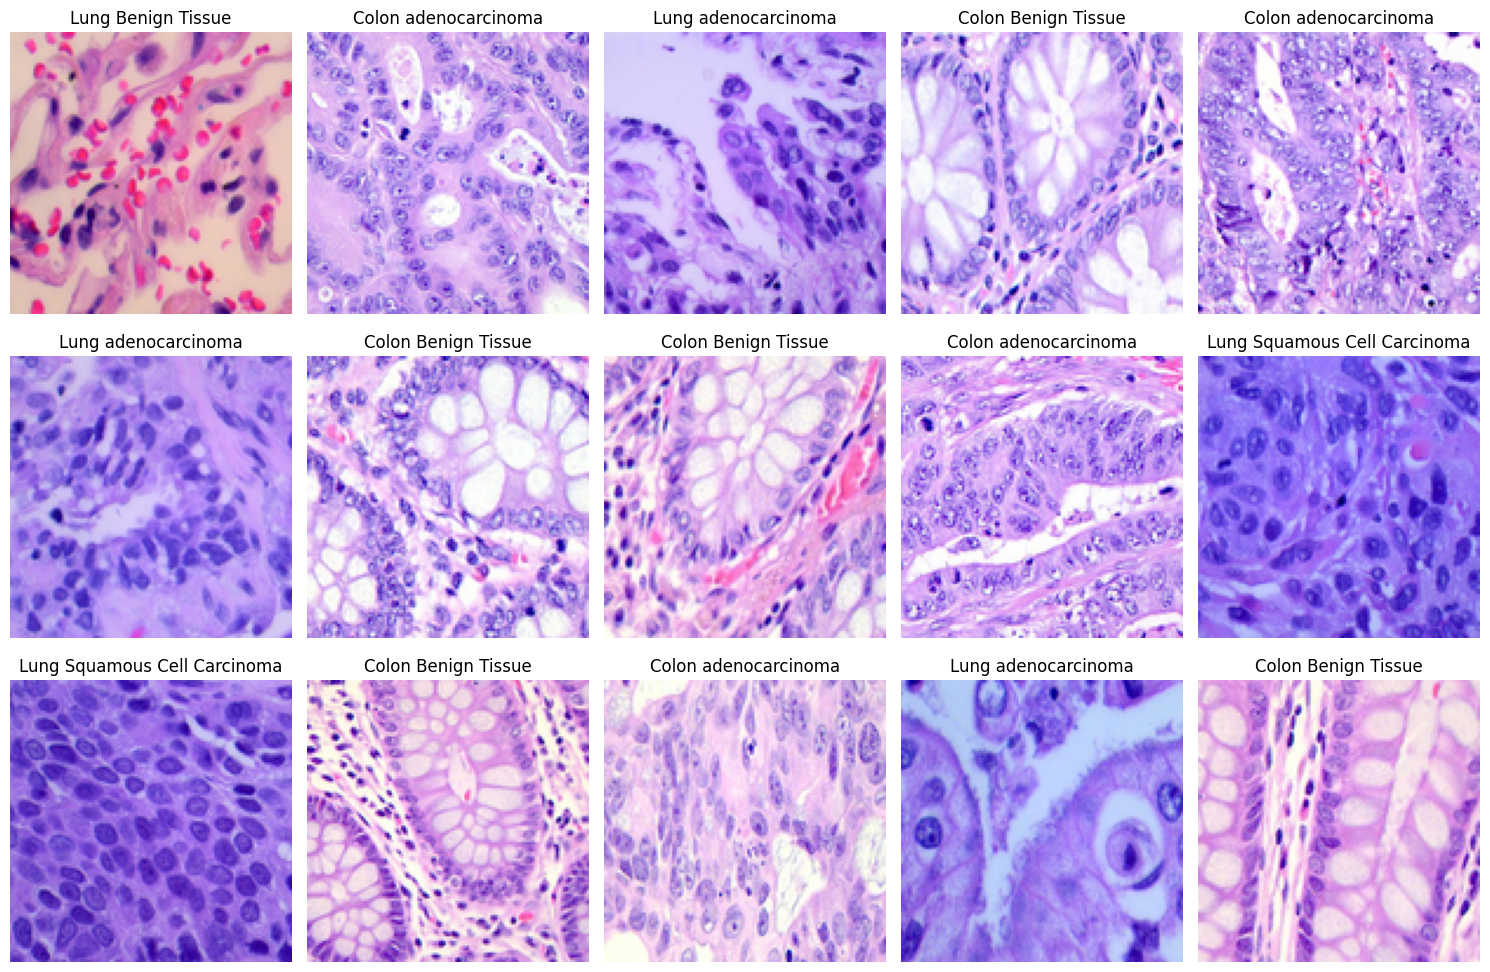

In [ ]:
indices = np.random.choice(range(data.shape[0]), 15, replace=False)

# Create a figure to display the images and labels
plt.figure(figsize=(15, 10))

for i, idx in enumerate(indices, 1):
    plt.subplot(3,5, i)
    plt.imshow(data[idx])
    plt.title(labels[idx])
    plt.axis('off')

plt.tight_layout()
plt.show()

## **Visualize Class Distribution**

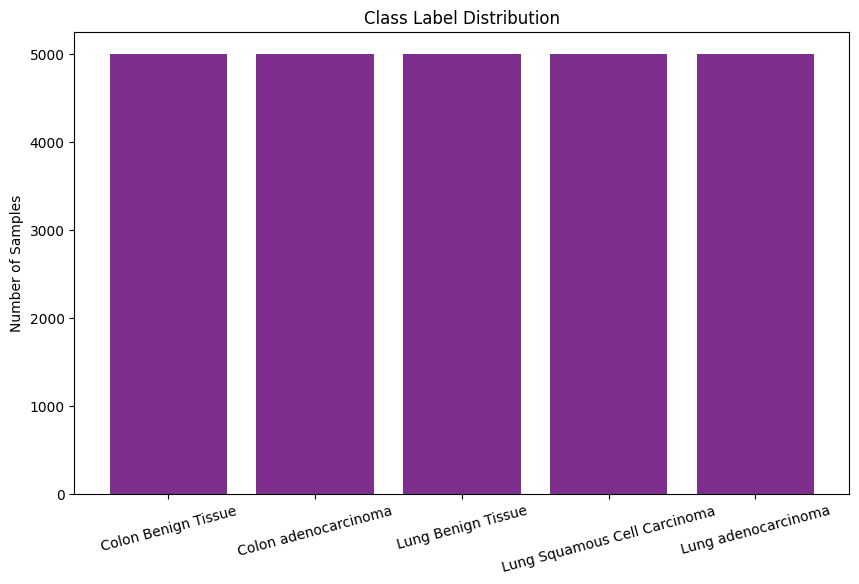

In [5]:
#Get unique label names and amount
u_labels, counts = np.unique(labels, return_counts=True)

plt.figure(figsize=(10, 6))
plt.bar(u_labels, counts, color="#7E2F8E")
plt.title('Class Label Distribution')
plt.ylabel('Number of Samples')
plt.xticks(rotation=15)
plt.show()

## **Train-Test Split**

In [6]:
#Training set (60% of the data)
#Validation set (20% of the data)
#Test set (20% of the data)

# Split data into training_validation and test sets
X_trainval, X_test, y_trainval, y_test = train_test_split(data, one_hot_labels, test_size=0.2, stratify= integer_encoded, random_state=42)

# Split training_validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, stratify=y_trainval, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

(15000, 120, 120, 3) (5000, 120, 120, 3) (5000, 120, 120, 3)


# **Baseline Model**

### **Build Baseline Model**

In [17]:
# Define the model
model = Sequential()

# First Convolutional Block
model.add(Conv2D(128, (3, 3), padding='same', activation='relu', input_shape= X_train.shape[1:]))
model.add(MaxPooling2D((2, 2)))

# Second Convolutional Block
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flattening the convolutional layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))

# Output Layer for Multiclass Classification
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### **Baseline Model Summary**

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 60, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 128)               7

### **Train Baseline Model**

In [18]:
history = model.fit(X_train, y_train, epochs= 10, batch_size= 32, validation_data=(X_val, y_val))
test_loss_base, test_acc_base = model.evaluate(X_test, y_test)

Epoch 1/10
469/469 [==============================] - 20s 35ms/step - loss: 2.5827 - accuracy: 0.4306 - val_loss: 1.1485 - val_accuracy: 0.4758
Epoch 2/10
469/469 [==============================] - 15s 32ms/step - loss: 0.9180 - accuracy: 0.5624 - val_loss: 0.9052 - val_accuracy: 0.5578
Epoch 3/10
469/469 [==============================] - 15s 32ms/step - loss: 0.8215 - accuracy: 0.6044 - val_loss: 0.8354 - val_accuracy: 0.5876
Epoch 4/10
469/469 [==============================] - 16s 35ms/step - loss: 0.7740 - accuracy: 0.6394 - val_loss: 0.6739 - val_accuracy: 0.6882
Epoch 5/10
469/469 [==============================] - 15s 32ms/step - loss: 0.7243 - accuracy: 0.6735 - val_loss: 0.6455 - val_accuracy: 0.7110
Epoch 6/10
469/469 [==============================] - 15s 32ms/step - loss: 0.6241 - accuracy: 0.7265 - val_loss: 0.7227 - val_accuracy: 0.7534
Epoch 7/10
469/469 [==============================] - 15s 32ms/step - loss: 0.6084 - accuracy: 0.7406 - val_loss: 0.6800 - val_accuracy:

## **Evaluation Metrics for Baseline Model**

### **Loss and Accuracy for Train and Validation Set**

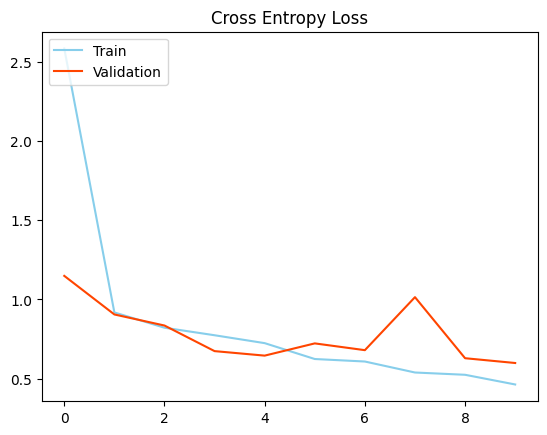

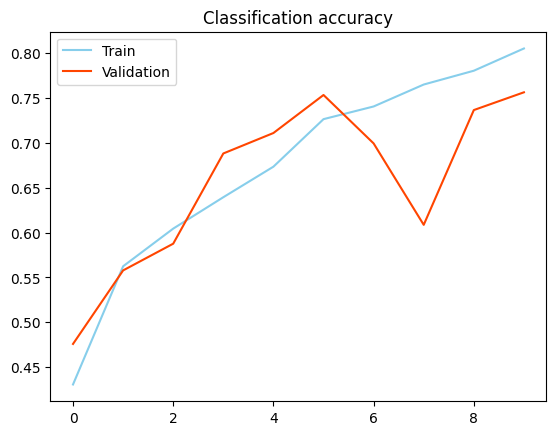

In [19]:
# Plot training & validation loss values
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='skyblue', label='train')
plt.plot(history.history['val_loss'], color='orangered', label='test')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# Plot training & validation accuracy values
plt.title('Classification accuracy')
plt.plot(history.history['accuracy'], color= 'skyblue', label = 'train' )
plt.plot(history.history['val_accuracy'], color = 'orangered', label = 'test')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### **Confusion Matrices for Validation and Test set**

157/157 [==============================] - 1s 7ms/step


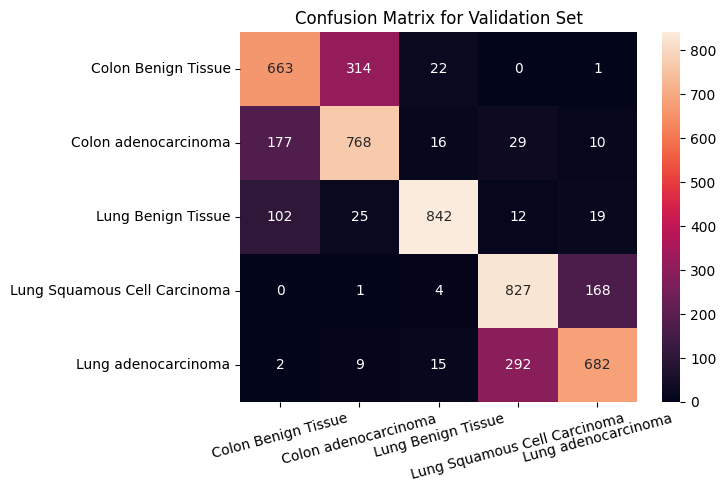

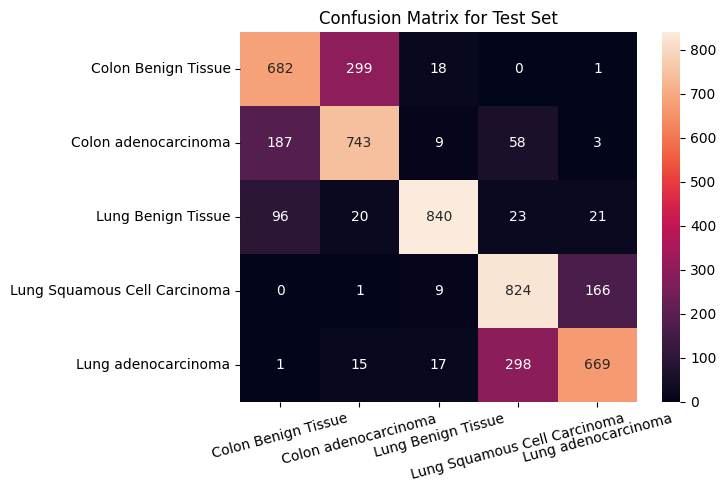

In [20]:
# Get predictions for both sets
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Convert predictions to class labels
y_val_pred_labels = np.argmax(y_val_pred, axis=1)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

# Convert observations to class labels
y_val_true = np.argmax(y_val, axis=1)
y_test_true = np.argmax(y_test, axis=1)

# Confusion matrix for the validation set
cm_val = confusion_matrix(y_val_true, y_val_pred_labels)
sns.heatmap(cm_val, annot=True, fmt="d", xticklabels= u_labels, yticklabels=u_labels)
plt.title('Confusion Matrix for Validation Set')
plt.xticks(rotation=15)
plt.show()

# Confusion matrix for the test set
cm_test = confusion_matrix(y_test_true, y_test_pred_labels)
sns.heatmap(cm_test, annot=True, fmt="d", xticklabels=u_labels, yticklabels=u_labels)
plt.title('Confusion Matrix for Test Set')
plt.xticks(rotation=15)
plt.show()

### **ROC Curve for Validation and Test set**

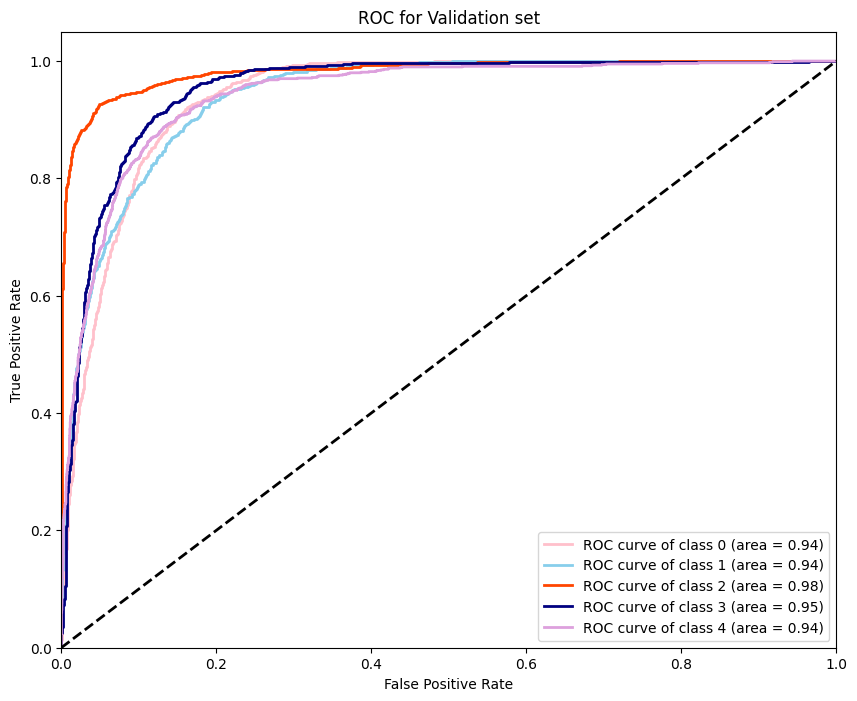

In [24]:
'''Validation Set'''
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_val_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

colors = ['pink', 'skyblue', 'orangered', 'navy', 'plum']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Validation set')
plt.legend(loc="lower right")
plt.show()


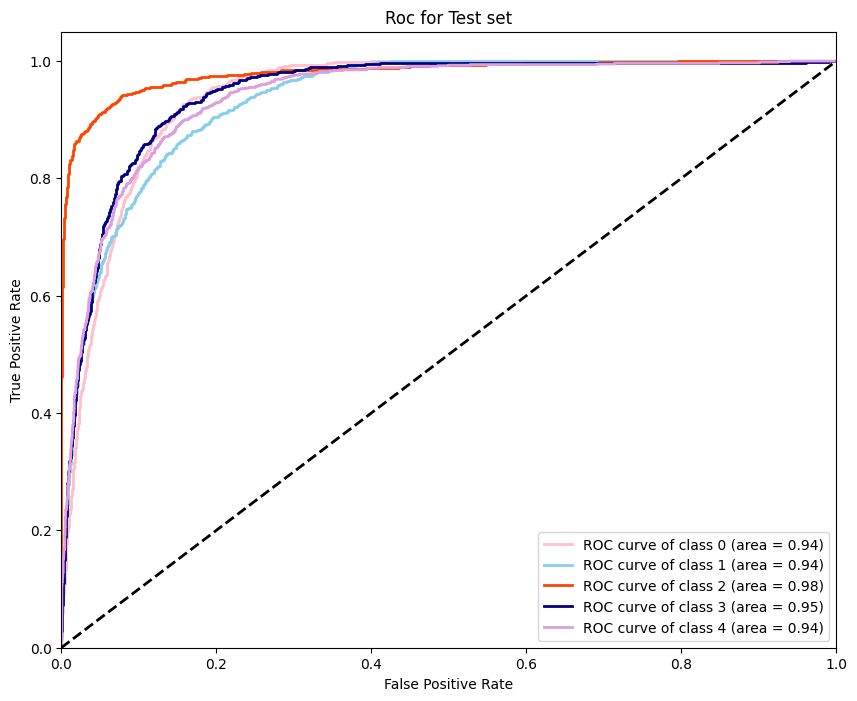

In [25]:
'''Test Set'''
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_test_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

colors = ['pink', 'skyblue', 'orangered', 'navy', 'plum']
for i, color in zip(range(5), colors[:5]):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc for Test set')
plt.legend(loc="lower right")
plt.show()

### **Performance Metrics**

In [23]:
# Classification Report for Validation Set
report_val_base = classification_report(y_val_true, y_val_pred_labels, target_names=u_labels)
print('')
print(f'Evaluation Metrics of the Baeline model - Validation set:\n{report_val_base}')

# Classification Report for Test Set
report_test_base = classification_report(y_test_true, y_test_pred_labels, target_names=u_labels)
print(f'Evaluation Metrics of the Baeline model - Test set:\n{report_test_base}')


Evaluation Metrics of the Baeline model - Validation set:
                              precision    recall  f1-score   support

         Colon Benign Tissue       0.70      0.66      0.68      1000
        Colon adenocarcinoma       0.69      0.77      0.73      1000
          Lung Benign Tissue       0.94      0.84      0.89      1000
Lung Squamous Cell Carcinoma       0.71      0.83      0.77      1000
         Lung adenocarcinoma       0.78      0.68      0.73      1000

                    accuracy                           0.76      5000
                   macro avg       0.76      0.76      0.76      5000
                weighted avg       0.76      0.76      0.76      5000

Evaluation Metrics of the Baeline model - Test set:
                              precision    recall  f1-score   support

         Colon Benign Tissue       0.71      0.68      0.69      1000
        Colon adenocarcinoma       0.69      0.74      0.72      1000
          Lung Benign Tissue       0.94      

# **Model Experimentation**

## **Optimizers**

### **RMSprop**

In [ ]:
model_RMS = Sequential()

# First Convolutional Block
model_RMS.add(Conv2D(128, (3, 3), padding='same', activation='relu', input_shape= X_train.shape[1:]))
model_RMS.add(MaxPooling2D((2, 2)))

# Second Convolutional Block
model_RMS.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_RMS.add(MaxPooling2D((2, 2)))

# Flattening the outputs from the convolutional layers to feed into the dense layers
model_RMS.add(Flatten())
model_RMS.add(Dense(128, activation='relu'))
model_RMS.add(Dense(32, activation='relu'))

# Output Layer for Multiclass Classification
model_RMS.add(Dense(5, activation='softmax'))

# Compile the model with the RMSprop optimizer and a learning rate of 0.001
model_RMS.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history_RMS = model_RMS.fit(X_train, y_train, epochs= 10, batch_size= 32, validation_data=(X_val, y_val))
test_loss_RMS, test_acc_RMS = model_RMS.evaluate(X_test, y_test)

Epoch 1/10
469/469 [==============================] - 17s 33ms/step - loss: 12.1037 - accuracy: 0.4971 - val_loss: 0.6913 - val_accuracy: 0.6280
Epoch 2/10
469/469 [==============================] - 16s 34ms/step - loss: 0.8495 - accuracy: 0.6145 - val_loss: 0.6544 - val_accuracy: 0.6508
Epoch 3/10
469/469 [==============================] - 15s 31ms/step - loss: 0.9574 - accuracy: 0.6651 - val_loss: 69.3730 - val_accuracy: 0.2026
Epoch 4/10
469/469 [==============================] - 15s 31ms/step - loss: 0.9940 - accuracy: 0.6933 - val_loss: 0.7540 - val_accuracy: 0.6938
Epoch 5/10
469/469 [==============================] - 15s 31ms/step - loss: 0.9671 - accuracy: 0.7238 - val_loss: 0.6480 - val_accuracy: 0.7080
Epoch 6/10
469/469 [==============================] - 15s 31ms/step - loss: 0.6897 - accuracy: 0.7507 - val_loss: 0.6790 - val_accuracy: 0.7238
Epoch 7/10
469/469 [==============================] - 15s 31ms/step - loss: 0.7212 - accuracy: 0.7906 - val_loss: 0.6097 - val_accurac

### **Nadam**

In [ ]:
model_ND = Sequential()

# First Convolutional Block
model_ND.add(Conv2D(128, (3, 3), padding='same', activation='relu', input_shape= X_train.shape[1:]))
model_ND.add(MaxPooling2D((2, 2)))

# Second Convolutional Block
model_ND.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_ND.add(MaxPooling2D((2, 2)))

# Flattening the outputs from the convolutional layers to feed into the dense layers
model_ND.add(Flatten())
model_ND.add(Dense(128, activation='relu'))
model_ND.add(Dense(32, activation='relu'))

# Output Layer for Multiclass Classification
model_ND.add(Dense(5, activation='softmax'))

# Compile the model with the Nadam optimizer and a learning rate of 0.001
model_ND.compile(optimizer=Nadam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history_ND = model_ND.fit(X_train, y_train, epochs= 10, batch_size= 32, validation_data=(X_val, y_val))
test_loss_ND, test_acc_ND = model_ND.evaluate(X_test, y_test)

Epoch 1/10
469/469 [==============================] - 25s 39ms/step - loss: 3.5855 - accuracy: 0.6439 - val_loss: 0.5738 - val_accuracy: 0.7314
Epoch 2/10
469/469 [==============================] - 16s 34ms/step - loss: 0.5421 - accuracy: 0.7492 - val_loss: 0.4718 - val_accuracy: 0.7746
Epoch 3/10
469/469 [==============================] - 16s 34ms/step - loss: 0.4874 - accuracy: 0.7800 - val_loss: 0.4461 - val_accuracy: 0.8042
Epoch 4/10
469/469 [==============================] - 16s 34ms/step - loss: 0.3944 - accuracy: 0.8217 - val_loss: 0.5117 - val_accuracy: 0.7842
Epoch 5/10
469/469 [==============================] - 17s 36ms/step - loss: 0.3436 - accuracy: 0.8529 - val_loss: 0.4079 - val_accuracy: 0.8212
Epoch 6/10
469/469 [==============================] - 17s 36ms/step - loss: 0.3091 - accuracy: 0.8677 - val_loss: 0.4780 - val_accuracy: 0.8344
Epoch 7/10
469/469 [==============================] - 17s 35ms/step - loss: 0.2543 - accuracy: 0.8970 - val_loss: 0.4706 - val_accuracy:

### **Adamax**

In [ ]:
model_ADMX = Sequential()

# First Convolutional Block
model_ADMX.add(Conv2D(128, (3, 3), padding='same', activation='relu', input_shape= X_train.shape[1:]))
model_ADMX.add(MaxPooling2D((2, 2)))

# Second Convolutional Block
model_ADMX.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_ADMX.add(MaxPooling2D((2, 2)))

# Flattening the outputs from the convolutional layers to feed into the dense layers
model_ADMX.add(Flatten())
model_ADMX.add(Dense(128, activation='relu'))
model_ADMX.add(Dense(32, activation='relu'))

# Output Layer for Multiclass Classification
model_ADMX.add(Dense(5, activation='softmax'))

# Compile the model with the SGD optimizer and a learning rate of 0.001
model_ADMX.compile(optimizer=Adamax(learning_rate= 0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history_ADMX = model_ADMX.fit(X_train, y_train, epochs= 10, batch_size= 32, validation_data=(X_val, y_val))
test_loss_ADMX, test_acc_ADMX = model_ADMX.evaluate(X_test, y_test)

Epoch 1/10
469/469 [==============================] - 23s 37ms/step - loss: 5.4561 - accuracy: 0.7173 - val_loss: 0.4080 - val_accuracy: 0.8214
Epoch 2/10
469/469 [==============================] - 15s 33ms/step - loss: 0.3734 - accuracy: 0.8417 - val_loss: 0.4018 - val_accuracy: 0.8322
Epoch 3/10
469/469 [==============================] - 15s 33ms/step - loss: 0.2948 - accuracy: 0.8808 - val_loss: 0.4194 - val_accuracy: 0.8382
Epoch 4/10
469/469 [==============================] - 15s 33ms/step - loss: 0.2541 - accuracy: 0.8977 - val_loss: 0.4366 - val_accuracy: 0.8342
Epoch 5/10
469/469 [==============================] - 15s 33ms/step - loss: 0.2131 - accuracy: 0.9167 - val_loss: 0.4031 - val_accuracy: 0.8494
Epoch 6/10
469/469 [==============================] - 17s 36ms/step - loss: 0.1952 - accuracy: 0.9244 - val_loss: 0.4322 - val_accuracy: 0.8408
Epoch 7/10
469/469 [==============================] - 15s 33ms/step - loss: 0.1384 - accuracy: 0.9458 - val_loss: 0.4080 - val_accuracy:

### **Best Optimizer**

In [ ]:
# Find minimum loss
min_loss_value = min(test_loss_ADMX, test_loss_ND, test_loss_RMS)
if min_loss_value == test_loss_ADMX:
    print("Adamax has the minimum loss:", min_loss_value)
elif min_loss_value == test_loss_ND:
    print("Nadam has the minimum loss:", min_loss_value)
else:
    print("RMSprop  has the minimum loss:", min_loss_value)

# Find maximum accuracy
max_acc_value = max(test_acc_ADMX, test_acc_ND, test_acc_RMS)
if max_acc_value == test_acc_ADMX:
    print("Adamax has the maximum accuracy:", max_acc_value)
elif max_acc_value == test_acc_ND:
    print("Nadam has the maximum accuracy:", max_acc_value)
else:
    print("RMSprop has the maximum accuracy:", max_acc_value)

Adamax has the minimum loss: 0.43112388253211975
Adamax has the maximum accuracy: 0.876800000667572


## **Activation Function**

### **Leaky ReLU**

In [ ]:
model_LR = Sequential()

# First Convolutional Block
model_LR.add(Conv2D(128, (3, 3), padding='same', input_shape= X_train.shape[1:]))
model_LR.add(MaxPooling2D((2, 2)))
model_LR.add(LeakyReLU(alpha=0.01))

# Second Convolutional Block
model_LR.add(Conv2D(64, (3, 3)))
model_LR.add(MaxPooling2D((2, 2)))
model_LR.add(LeakyReLU(alpha=0.01))

# Flattening the outputs from the convolutional layers to feed into the dense layers
model_LR.add(Flatten())
model_LR.add(Dense(128))
model_LR.add(LeakyReLU(alpha=0.01))
model_LR.add(Dense(32))
model_LR.add(LeakyReLU(alpha=0.01))

# Output Layer for Multiclass Classification
model_LR.add(Dense(5, activation='softmax'))

# Compile the model with the SGD optimizer and a learning rate of 0.001
model_LR.compile(optimizer=Adamax(learning_rate= 0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_LR.fit(X_train, y_train, epochs= 10, batch_size= 32, validation_data=(X_val, y_val))
test_loss_LR, test_acc_LR = model_LR.evaluate(X_test, y_test)

Epoch 1/10
469/469 [==============================] - 20s 38ms/step - loss: 12.5192 - accuracy: 0.7116 - val_loss: 0.3960 - val_accuracy: 0.8458
Epoch 2/10
469/469 [==============================] - 17s 37ms/step - loss: 0.4019 - accuracy: 0.8445 - val_loss: 0.4029 - val_accuracy: 0.8544
Epoch 3/10
469/469 [==============================] - 17s 37ms/step - loss: 0.3044 - accuracy: 0.8819 - val_loss: 0.3502 - val_accuracy: 0.8658
Epoch 4/10
469/469 [==============================] - 17s 35ms/step - loss: 0.2864 - accuracy: 0.8946 - val_loss: 0.5207 - val_accuracy: 0.8410
Epoch 5/10
469/469 [==============================] - 16s 35ms/step - loss: 0.2422 - accuracy: 0.9112 - val_loss: 0.3550 - val_accuracy: 0.8698
Epoch 6/10
469/469 [==============================] - 16s 35ms/step - loss: 0.2089 - accuracy: 0.9231 - val_loss: 0.4811 - val_accuracy: 0.8810
Epoch 7/10
469/469 [==============================] - 16s 35ms/step - loss: 0.2020 - accuracy: 0.9309 - val_loss: 0.4077 - val_accuracy

### **Compare Leaky ReLU to ReLU**

In [ ]:
# Find minimum loss
min_loss_value = min(test_loss_base, test_loss_LR)
if min_loss_value == test_loss_base:
    print("ReLU has the minimum loss:", min_loss_value)
elif min_loss_value == test_loss_LR:
    print("Leaky ReLU has the minimum loss:", min_loss_value)

# Find maximum accuracy
max_acc_value = max(test_acc_base, test_acc_LR)
if max_acc_value == test_acc_base:
    print("ReLU has the maximum accuracy:", max_acc_value)
elif max_acc_value == test_acc_LR:
    print("Leaky ReLU has the maximum accuracy:", max_acc_value)

Leaky ReLU has the minimum loss: 0.4128299355506897
Leaky ReLU has the maximum accuracy: 0.9064000248908997


## **Model Structure**

In [8]:
model_1 = Sequential()

# First Block
model_1.add(Conv2D(16, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model_1.add(LeakyReLU(alpha=0.01))
model_1.add(Conv2D(32, (3, 3), padding='same'))
model_1.add(LeakyReLU(alpha=0.01))
model_1.add(MaxPooling2D((2, 2)))

# Second Block
model_1.add(Conv2D(64, (3, 3), padding='same'))
model_1.add(LeakyReLU(alpha=0.01))
model_1.add(Conv2D(128, (3, 3), padding='same'))
model_1.add(LeakyReLU(alpha=0.01))
model_1.add(MaxPooling2D((2, 2)))

# Third Block
model_1.add(Conv2D(256, (3, 3), padding='same'))
model_1.add(LeakyReLU(alpha=0.01))
model_1.add(Conv2D(512, (3, 3), padding='same'))
model_1.add(LeakyReLU(alpha=0.01))
model_1.add(MaxPooling2D((2, 2)))

# Flattening the outputs from the convolutional layers to feed into the dense layers
model_1.add(Flatten())
model_1.add(Dense(256))
model_1.add(LeakyReLU(alpha=0.01))
model_1.add(Dense(64))
model_1.add(LeakyReLU(alpha=0.01))

# Output Layer for Multiclass Classification
model_1.add(Dense(5, activation='softmax'))

# Compile the model
model_1.compile(optimizer=Adamax(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Training the model
history_1 = model_1.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Evaluating the model
test_loss_1, test_acc_1 = model_1.evaluate(X_test, y_test)


Epoch 1/10
469/469 [==============================] - 45s 87ms/step - loss: 7.4355 - accuracy: 0.7221 - val_loss: 0.5585 - val_accuracy: 0.7830
Epoch 2/10
469/469 [==============================] - 38s 82ms/step - loss: 0.3500 - accuracy: 0.8555 - val_loss: 0.3121 - val_accuracy: 0.8698
Epoch 3/10
469/469 [==============================] - 39s 84ms/step - loss: 0.2880 - accuracy: 0.8823 - val_loss: 0.2521 - val_accuracy: 0.8914
Epoch 4/10
469/469 [==============================] - 40s 85ms/step - loss: 0.2176 - accuracy: 0.9126 - val_loss: 0.1965 - val_accuracy: 0.9280
Epoch 5/10
469/469 [==============================] - 39s 84ms/step - loss: 0.1638 - accuracy: 0.9364 - val_loss: 0.2073 - val_accuracy: 0.9220
Epoch 6/10
469/469 [==============================] - 39s 83ms/step - loss: 0.1051 - accuracy: 0.9617 - val_loss: 0.1450 - val_accuracy: 0.9414
Epoch 7/10
469/469 [==============================] - 40s 84ms/step - loss: 0.0829 - accuracy: 0.9691 - val_loss: 0.1594 - val_accuracy:

In [9]:
model_2 = Sequential()

# First Block
model_2.add(Conv2D(16, (3, 3), padding='same', input_shape= X_train.shape[1:]))
model_2.add(LeakyReLU(alpha=0.01))
model_2.add(Conv2D(32, (3, 3), padding='same'))
model_2.add(LeakyReLU(alpha=0.01))
model_2.add(MaxPooling2D((2, 2)))

# Second Block
model_2.add(Conv2D(64, (3, 3), padding='same'))
model_2.add(LeakyReLU(alpha=0.01))
model_2.add(Conv2D(128, (3, 3), padding='same'))
model_2.add(LeakyReLU(alpha=0.01))
model_2.add(Conv2D(128, (3, 3), padding='same'))
model_2.add(LeakyReLU(alpha=0.01))
model_2.add(MaxPooling2D((2, 2)))

# Third Block
model_2.add(Conv2D(256, (3, 3), padding='same'))
model_2.add(LeakyReLU(alpha=0.01))
model_2.add(Conv2D(512, (3, 3), padding='same'))
model_2.add(LeakyReLU(alpha=0.01))
model_2.add(MaxPooling2D((2, 2)))

# Flattening the outputs from the convolutional layers to feed into the dense layers
model_2.add(Flatten())
model_2.add(Dense(256))
model_2.add(LeakyReLU(alpha=0.01))
model_2.add(Dense(64))
model_2.add(LeakyReLU(alpha=0.01))

# Output Layer for Multiclass Classification
model_2.add(Dense(5, activation='softmax'))

# Compile the model
model_2.compile(optimizer=Adamax(learning_rate= 0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
history_2 = model_2.fit(X_train, y_train, epochs= 10, batch_size= 32, validation_data=(X_val, y_val))
test_loss_2, test_acc_2 = model_2.evaluate(X_test, y_test)

Epoch 1/10
469/469 [==============================] - 52s 103ms/step - loss: 5.0555 - accuracy: 0.6916 - val_loss: 0.4082 - val_accuracy: 0.8250
Epoch 2/10
469/469 [==============================] - 46s 99ms/step - loss: 0.4078 - accuracy: 0.8215 - val_loss: 0.2969 - val_accuracy: 0.8788
Epoch 3/10
469/469 [==============================] - 47s 99ms/step - loss: 0.2979 - accuracy: 0.8789 - val_loss: 0.2057 - val_accuracy: 0.9190
Epoch 4/10
469/469 [==============================] - 46s 99ms/step - loss: 0.2132 - accuracy: 0.9171 - val_loss: 0.2244 - val_accuracy: 0.9100
Epoch 5/10
469/469 [==============================] - 47s 99ms/step - loss: 0.1714 - accuracy: 0.9318 - val_loss: 0.2044 - val_accuracy: 0.9320
Epoch 6/10
469/469 [==============================] - 46s 99ms/step - loss: 0.1345 - accuracy: 0.9483 - val_loss: 0.1992 - val_accuracy: 0.9402
Epoch 7/10
469/469 [==============================] - 46s 99ms/step - loss: 0.0989 - accuracy: 0.9627 - val_loss: 0.5348 - val_accuracy

In [10]:
model_3 = Sequential()

# First Block
model_3.add(Conv2D(16, (3, 3), padding='same', input_shape= X_train.shape[1:]))
model_3.add(LeakyReLU(alpha=0.01))
model_3.add(Conv2D(16, (3, 3), padding='same'))
model_3.add(LeakyReLU(alpha=0.01))
model_3.add(MaxPooling2D((2, 2)))

# Second Block
model_3.add(Conv2D(32, (3, 3), padding='same'))
model_3.add(LeakyReLU(alpha=0.01))
model_3.add(Conv2D(32, (3, 3), padding='same'))
model_3.add(LeakyReLU(alpha=0.01))
model_3.add(MaxPooling2D((2, 2)))

# Third Block
model_3.add(Conv2D(64, (3, 3), padding='same'))
model_3.add(LeakyReLU(alpha=0.01))
model_3.add(Conv2D(128, (3, 3), padding='same'))
model_3.add(LeakyReLU(alpha=0.01))
model_3.add(MaxPooling2D((2, 2)))

# Fourth Block
model_3.add(Conv2D(256, (3, 3), padding='same'))
model_3.add(LeakyReLU(alpha=0.01))
model_3.add(Conv2D(512, (3, 3), padding='same'))
model_3.add(LeakyReLU(alpha=0.01))
model_3.add(MaxPooling2D((2, 2)))

# Flattening the outputs from the convolutional layers to feed into the dense layers
model_3.add(Flatten())
model_3.add(Dense(256))
model_3.add(LeakyReLU(alpha=0.01))
model_3.add(Dense(64))
model_3.add(LeakyReLU(alpha=0.01))

# Output Layer for Multiclass Classification
model_3.add(Dense(5, activation='softmax'))

# Compile the model
model_3.compile(optimizer=Adamax(learning_rate= 0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
history_3 = model_3.fit(X_train, y_train, epochs= 10, batch_size= 32, validation_data=(X_val, y_val))
test_loss_3, test_acc_3 = model_3.evaluate(X_test, y_test)

Epoch 1/10
469/469 [==============================] - 25s 43ms/step - loss: 0.7923 - accuracy: 0.6867 - val_loss: 0.4759 - val_accuracy: 0.7764
Epoch 2/10
469/469 [==============================] - 17s 37ms/step - loss: 0.3252 - accuracy: 0.8653 - val_loss: 0.1976 - val_accuracy: 0.9248
Epoch 3/10
469/469 [==============================] - 18s 38ms/step - loss: 0.2117 - accuracy: 0.9175 - val_loss: 0.2721 - val_accuracy: 0.8960
Epoch 4/10
469/469 [==============================] - 18s 38ms/step - loss: 0.1412 - accuracy: 0.9457 - val_loss: 0.1379 - val_accuracy: 0.9454
Epoch 5/10
469/469 [==============================] - 18s 38ms/step - loss: 0.0949 - accuracy: 0.9632 - val_loss: 0.1209 - val_accuracy: 0.9554
Epoch 6/10
469/469 [==============================] - 18s 38ms/step - loss: 0.0907 - accuracy: 0.9643 - val_loss: 0.0692 - val_accuracy: 0.9720
Epoch 7/10
469/469 [==============================] - 18s 38ms/step - loss: 0.0730 - accuracy: 0.9715 - val_loss: 0.0667 - val_accuracy:

### **Compare Models**

In [16]:
#Loss of the three models
print('The loss of model 1 is:', test_loss_1, '\nThe loss of model 2 is:', test_loss_2, '\nThe loss of model_3 is:', test_loss_3, '\n')

#Accuracy of the three models
print('The accuracy of model 1 is:', test_acc_1, '\nThe accuracy of model 2 is:', test_acc_2, '\nThe accuracy of model_3 is:', test_acc_3)


The loss of model 1 is: 0.11341015994548798 
The loss of model 2 is: 0.2217532992362976 
The loss of model_3 is: 0.07546047121286392 

The accuracy of model 1 is: 0.9610000252723694 
The accuracy of model 2 is: 0.9373999834060669 
The accuracy of model_3 is: 0.9843999743461609


### **Epoch amount - Early Stopping**

In [15]:
from keras.callbacks import EarlyStopping

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               verbose=1,
                               mode='min',
                               restore_best_weights=True)

# Add the callback to the model's fit method
history_1 = model_1.fit(X_train, y_train, epochs=50, batch_size=32,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping])

Epoch 1/50
469/469 [==============================] - 41s 87ms/step - loss: 0.0186 - accuracy: 0.9938 - val_loss: 0.0975 - val_accuracy: 0.9690
Epoch 2/50
469/469 [==============================] - 40s 85ms/step - loss: 0.0284 - accuracy: 0.9901 - val_loss: 0.0879 - val_accuracy: 0.9772
Epoch 3/50
469/469 [==============================] - 41s 87ms/step - loss: 0.0290 - accuracy: 0.9898 - val_loss: 0.1985 - val_accuracy: 0.9438
Epoch 4/50
469/469 [==============================] - 40s 85ms/step - loss: 0.0225 - accuracy: 0.9927 - val_loss: 0.2274 - val_accuracy: 0.9406
Epoch 5/50
469/469 [==============================] - 41s 88ms/step - loss: 0.0089 - accuracy: 0.9971 - val_loss: 0.1007 - val_accuracy: 0.9798
Epoch 6/50
469/469 [==============================] - 42s 89ms/step - loss: 1.2955e-04 - accuracy: 1.0000 - val_loss: 0.1037 - val_accuracy: 0.9800
Epoch 7/50
469/469 [==============================] - 40s 86ms/step - loss: 3.4016e-05 - accuracy: 1.0000 - val_loss: 0.1073 - val_a

### **Model Fit of Final Model**

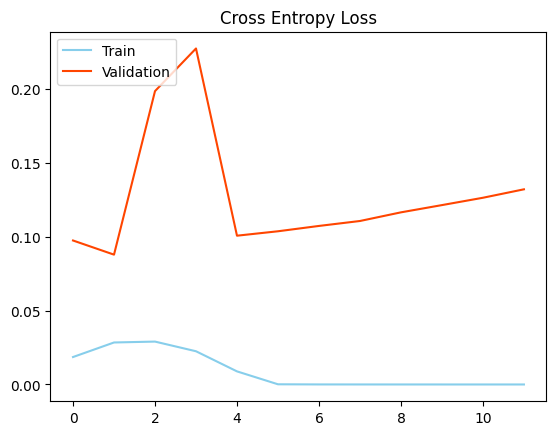

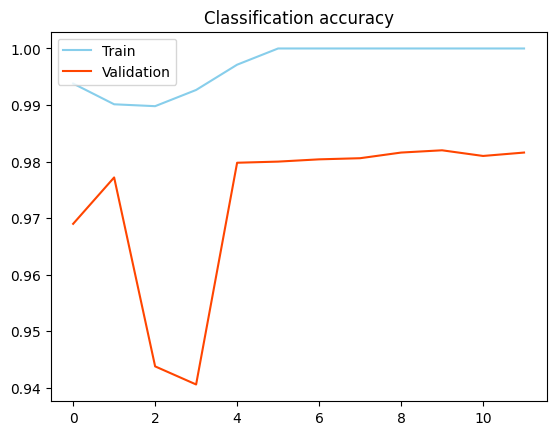

In [17]:
'''Fit of Best Model Structure to data'''
#LOSS & ACC
# Plot training & validation loss values
plt.title('Cross Entropy Loss')
plt.plot(history_1.history['loss'], color='skyblue', label='train')
plt.plot(history_1.history['val_loss'], color='orangered', label='test')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Plot training & validation accuracy values
plt.title('Classification accuracy')
plt.plot(history_1.history['accuracy'], color= 'skyblue', label = 'train' )
plt.plot(history_1.history['val_accuracy'], color = 'orangered', label = 'test')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## **Regularization**

### **L2**

In [7]:
model_L2 = Sequential()

# First Block
model_L2.add(Conv2D(16, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model_L2.add(LeakyReLU(alpha=0.01))
model_L2.add(Conv2D(32, (3, 3), padding='same'))
model_L2.add(LeakyReLU(alpha=0.01))
model_L2.add(MaxPooling2D((2, 2)))

# Second Block
model_L2.add(Conv2D(64, (3, 3), padding='same'))
model_L2.add(LeakyReLU(alpha=0.01))
model_L2.add(Conv2D(128, (3, 3), padding='same'))
model_L2.add(LeakyReLU(alpha=0.01))
model_L2.add(MaxPooling2D((2, 2)))

# Third Block
model_L2.add(Conv2D(256, (3, 3), padding='same'))
model_L2.add(LeakyReLU(alpha=0.01))
model_L2.add(Conv2D(512, (3, 3), padding='same'))
model_L2.add(LeakyReLU(alpha=0.01))
model_L2.add(MaxPooling2D((2, 2)))

# Flattening the outputs from the convolutional layers to feed into the dense layers
model_L2.add(Flatten())
model_L2.add(Dense(256, kernel_regularizer=l2(0.001)))
model_L2.add(LeakyReLU(alpha=0.01))
model_L2.add(Dense(64, kernel_regularizer=l2(0.001)))
model_L2.add(LeakyReLU(alpha=0.01))

# Output Layer for Multiclass Classification
model_L2.add(Dense(5, activation='softmax'))

# Compile the model
model_L2.compile(optimizer=Adamax(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

history_L2 = model_L2.fit(X_train, y_train, epochs= 12, batch_size=32, validation_data=(X_val, y_val))
test_loss_L2, test_acc_L2 = model_L2.evaluate(X_test, y_test)

Epoch 1/12
469/469 [==============================] - 53s 97ms/step - loss: 7.3072 - accuracy: 0.7501 - val_loss: 1.1404 - val_accuracy: 0.8112
Epoch 2/12
469/469 [==============================] - 40s 86ms/step - loss: 1.0173 - accuracy: 0.8660 - val_loss: 0.8867 - val_accuracy: 0.9124
Epoch 3/12
469/469 [==============================] - 42s 89ms/step - loss: 0.8982 - accuracy: 0.8958 - val_loss: 0.8839 - val_accuracy: 0.8866
Epoch 4/12
469/469 [==============================] - 39s 83ms/step - loss: 0.7611 - accuracy: 0.9319 - val_loss: 1.0075 - val_accuracy: 0.8266
Epoch 5/12
469/469 [==============================] - 41s 86ms/step - loss: 0.7053 - accuracy: 0.9394 - val_loss: 0.6583 - val_accuracy: 0.9528
Epoch 6/12
469/469 [==============================] - 41s 88ms/step - loss: 0.6052 - accuracy: 0.9591 - val_loss: 0.5978 - val_accuracy: 0.9492
Epoch 7/12
469/469 [==============================] - 42s 89ms/step - loss: 0.5344 - accuracy: 0.9677 - val_loss: 0.5771 - val_accuracy:

### **Dropout**

In [8]:
model_drop = Sequential()

# First Block
model_drop.add(Conv2D(16, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model_drop.add(LeakyReLU(alpha=0.01))
model_drop.add(Conv2D(32, (3, 3), padding='same'))
model_drop.add(LeakyReLU(alpha=0.01))
model_drop.add(MaxPooling2D((2, 2)))

# Second Block
model_drop.add(Conv2D(64, (3, 3), padding='same'))
model_drop.add(LeakyReLU(alpha=0.01))
model_drop.add(Conv2D(128, (3, 3), padding='same'))
model_drop.add(LeakyReLU(alpha=0.01))
model_drop.add(MaxPooling2D((2, 2)))
model_drop.add(Dropout(0.20))

# Third Block
model_drop.add(Conv2D(256, (3, 3), padding='same'))
model_drop.add(LeakyReLU(alpha=0.01))
model_drop.add(Conv2D(512, (3, 3), padding='same'))
model_drop.add(LeakyReLU(alpha=0.01))
model_drop.add(MaxPooling2D((2, 2)))
model_drop.add(Dropout(0.25))

# Flattening the convolutional layers into the dense layers
model_drop.add(Flatten())
model_drop.add(Dense(256))
model_drop.add(LeakyReLU(alpha=0.01))
model_drop.add(Dense(64))
model_drop.add(LeakyReLU(alpha=0.01))
model_drop.add(Dropout(0.25))

# Output Layer for Multiclass Classification
model_drop.add(Dense(5, activation='softmax'))

# Compile the model
model_drop.compile(optimizer=Adamax(learning_rate=0.001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

history_drop = model_drop.fit(X_train, y_train, epochs=12, batch_size=32, validation_data=(X_val, y_val))
test_loss_drop, test_acc_drop = model_drop.evaluate(X_test, y_test)

Epoch 1/12
469/469 [==============================] - 50s 99ms/step - loss: 2.4276 - accuracy: 0.5669 - val_loss: 0.7684 - val_accuracy: 0.6208
Epoch 2/12
469/469 [==============================] - 46s 99ms/step - loss: 0.6089 - accuracy: 0.7415 - val_loss: 0.3886 - val_accuracy: 0.8520
Epoch 3/12
469/469 [==============================] - 47s 100ms/step - loss: 0.3729 - accuracy: 0.8547 - val_loss: 0.2215 - val_accuracy: 0.9086
Epoch 4/12
469/469 [==============================] - 46s 99ms/step - loss: 0.2927 - accuracy: 0.8877 - val_loss: 0.3671 - val_accuracy: 0.8660
Epoch 5/12
469/469 [==============================] - 47s 100ms/step - loss: 0.2231 - accuracy: 0.9144 - val_loss: 0.2025 - val_accuracy: 0.9160
Epoch 6/12
469/469 [==============================] - 45s 96ms/step - loss: 0.2053 - accuracy: 0.9204 - val_loss: 0.1708 - val_accuracy: 0.9422
Epoch 7/12
469/469 [==============================] - 47s 100ms/step - loss: 0.1512 - accuracy: 0.9412 - val_loss: 0.2714 - val_accura

### **Combined Approach**

In [9]:
model_comb = Sequential()

# First Block
model_comb.add(Conv2D(16, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model_comb.add(LeakyReLU(alpha=0.01))
model_comb.add(Conv2D(32, (3, 3), padding='same'))
model_comb.add(LeakyReLU(alpha=0.01))
model_comb.add(MaxPooling2D((2, 2)))

# Second Block
model_comb.add(Conv2D(64, (3, 3), padding='same'))
model_comb.add(LeakyReLU(alpha=0.01))
model_comb.add(Conv2D(128, (3, 3), padding='same'))
model_comb.add(LeakyReLU(alpha=0.01))
model_comb.add(MaxPooling2D((2, 2)))
model_comb.add(Dropout(0.20))

# Third Block
model_comb.add(Conv2D(256, (3, 3), padding='same'))
model_comb.add(LeakyReLU(alpha=0.01))
model_comb.add(Conv2D(512, (3, 3), padding='same'))
model_comb.add(LeakyReLU(alpha=0.01))
model_comb.add(MaxPooling2D((2, 2)))
model_comb.add(Dropout(0.25))

# Flattening the convolutional layers into the dense layers
model_comb.add(Flatten())
model_comb.add(Dense(256, kernel_regularizer=l2(0.001)))
model_comb.add(LeakyReLU(alpha=0.01))
model_comb.add(Dense(64, kernel_regularizer=l2(0.001)))
model_comb.add(LeakyReLU(alpha=0.01))
model_comb.add(Dropout(0.25))

# Output Layer for Multiclass Classification
model_comb.add(Dense(5, activation='softmax'))

# Compile the model
model_comb.compile(optimizer=Adamax(learning_rate=0.001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

history_comb = model_comb.fit(X_train, y_train, epochs=12, batch_size=32, validation_data=(X_val, y_val))
test_loss_comb, test_acc_comb = model_comb.evaluate(X_test, y_test)


Epoch 1/12
469/469 [==============================] - 49s 101ms/step - loss: 4.8892 - accuracy: 0.6659 - val_loss: 1.3157 - val_accuracy: 0.7444
Epoch 2/12
469/469 [==============================] - 47s 99ms/step - loss: 1.1850 - accuracy: 0.8083 - val_loss: 1.0495 - val_accuracy: 0.8428
Epoch 3/12
469/469 [==============================] - 47s 99ms/step - loss: 1.0254 - accuracy: 0.8562 - val_loss: 0.8650 - val_accuracy: 0.9146
Epoch 4/12
469/469 [==============================] - 48s 102ms/step - loss: 0.8757 - accuracy: 0.8981 - val_loss: 0.9227 - val_accuracy: 0.8474
Epoch 5/12
469/469 [==============================] - 48s 102ms/step - loss: 0.7518 - accuracy: 0.9259 - val_loss: 0.6994 - val_accuracy: 0.9406
Epoch 6/12
469/469 [==============================] - 46s 99ms/step - loss: 0.6531 - accuracy: 0.9385 - val_loss: 0.7531 - val_accuracy: 0.8952
Epoch 7/12
469/469 [==============================] - 46s 99ms/step - loss: 0.5573 - accuracy: 0.9537 - val_loss: 0.4962 - val_accura

In [10]:
# Find minimum loss
min_loss_value = min(test_loss_L2, test_loss_drop, test_loss_comb)
if min_loss_value == test_loss_L2:
    print("L2 has the minimum loss:", min_loss_value)
elif min_loss_value == test_loss_drop:
    print("Dropout has the minimum loss:", min_loss_value)
else:
    print("Combined approach  has the minimum loss:", min_loss_value)

# Find maximum accuracy
max_acc_value = max(test_acc_L2, test_acc_drop, test_acc_comb)
if max_acc_value == test_acc_L2:
    print("L2 has the maximum accuracy:", max_acc_value)
elif max_acc_value == test_acc_drop:
    print("Dropout has the maximum accuracy:", max_acc_value)
else:
    print("Combined approach has the maximum accuracy:", max_acc_value)

Dropout has the minimum loss: 0.07929928600788116
Dropout has the maximum accuracy: 0.980400025844574


### **Model Fit Comparison**

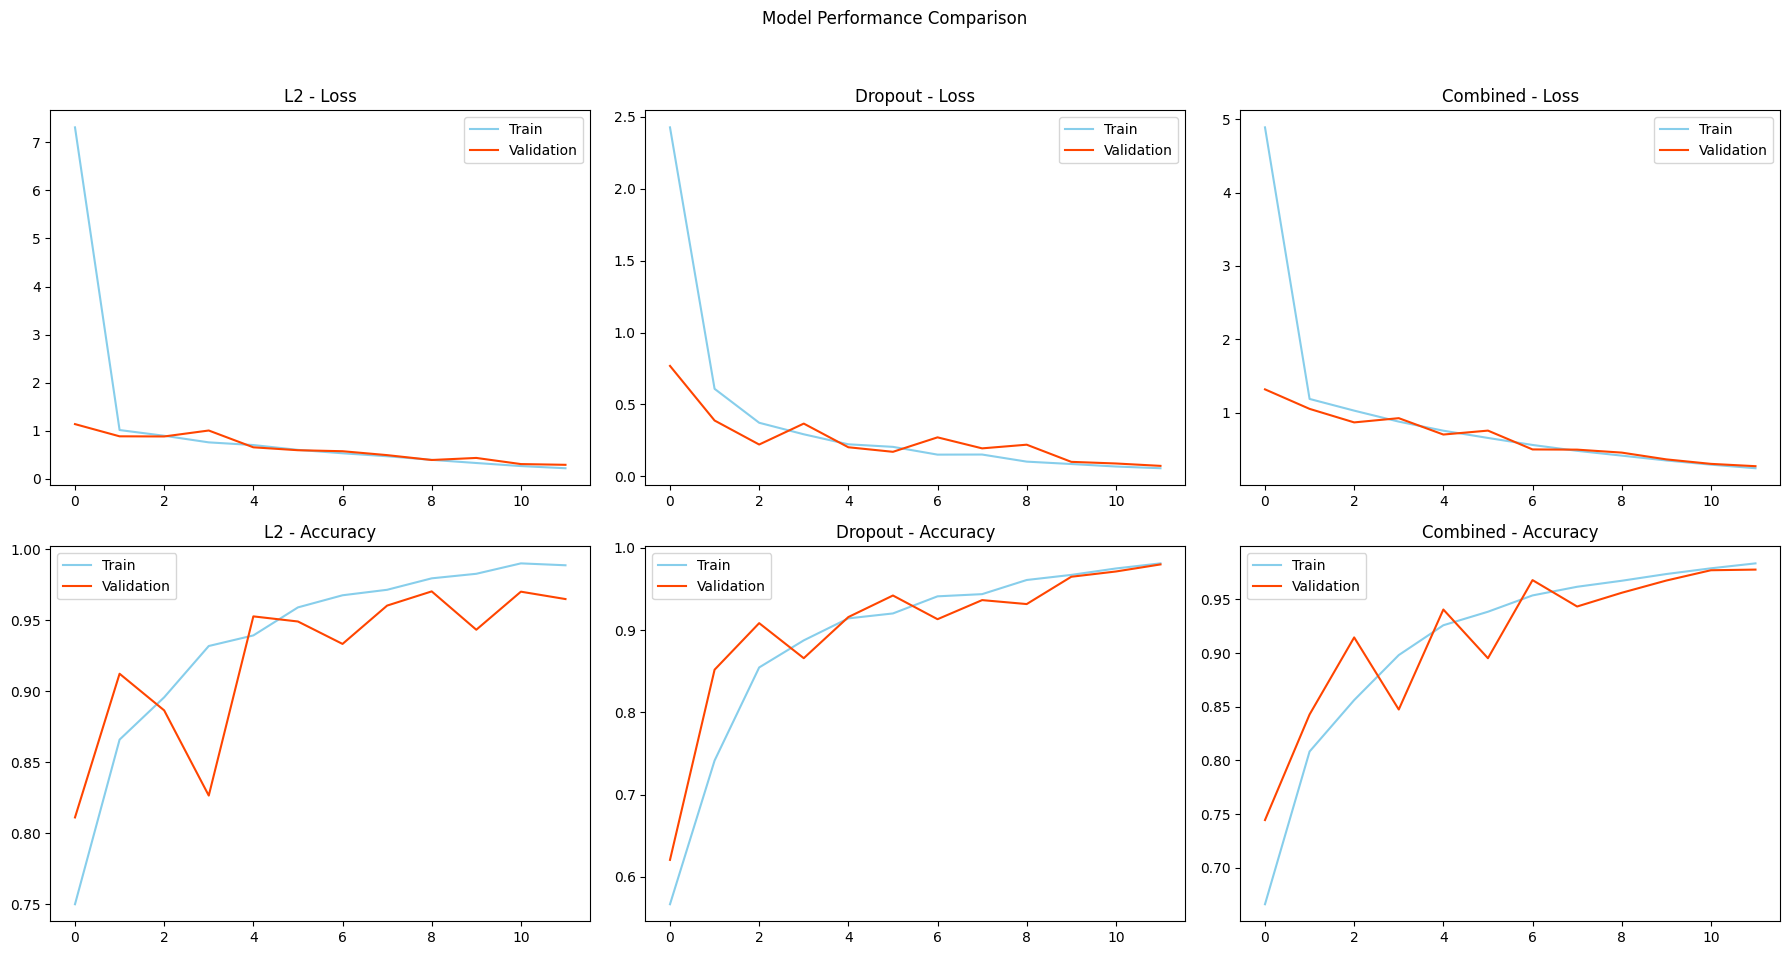

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
fig.suptitle('Model Performance Comparison')

# Plot Loss
axes[0, 0].plot(history_L2.history['loss'], color='skyblue', label='Train')
axes[0, 0].plot(history_L2.history['val_loss'], color='orangered', label='Validation')
axes[0, 0].set_title('L2 - Loss')
axes[0, 0].legend()

axes[0, 1].plot(history_drop.history['loss'], color='skyblue', label='Train')
axes[0, 1].plot(history_drop.history['val_loss'], color='orangered', label='Validation')
axes[0, 1].set_title('Dropout - Loss')
axes[0, 1].legend()

axes[0, 2].plot(history_comb.history['loss'], color='skyblue', label='Train')
axes[0, 2].plot(history_comb.history['val_loss'], color='orangered', label='Validation')
axes[0, 2].set_title('Combined - Loss')
axes[0, 2].legend()


# Plot Accuracy
axes[1, 0].plot(history_L2.history['accuracy'], color='skyblue', label='Train')
axes[1, 0].plot(history_L2.history['val_accuracy'], color='orangered', label='Validation')
axes[1, 0].set_title('L2 - Accuracy')
axes[1, 0].legend()

axes[1, 1].plot(history_drop.history['accuracy'], color='skyblue', label='Train')
axes[1, 1].plot(history_drop.history['val_accuracy'], color='orangered', label='Validation')
axes[1, 1].set_title('Dropout - Accuracy')
axes[1, 1].legend()

axes[1, 2].plot(history_comb.history['accuracy'], color='skyblue', label='Train')
axes[1, 2].plot(history_comb.history['val_accuracy'], color='orangered', label='Validation')
axes[1, 2].set_title('Combined - Accuracy')
axes[1, 2].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# **Enchanced Model**

### **Best Model Summary**

In [12]:
model_drop.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 120, 120, 16)      448       
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 120, 120, 16)      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 120, 120, 32)      4640      
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 120, 120, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 60, 60, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 64)        18496     
                                                      

## **Evaluation Metrics**

### **Loss and Accuracy**

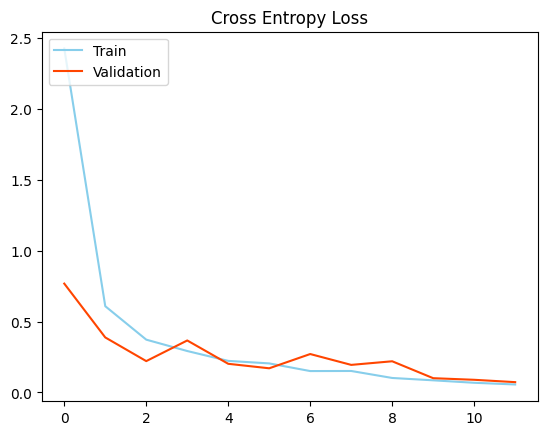

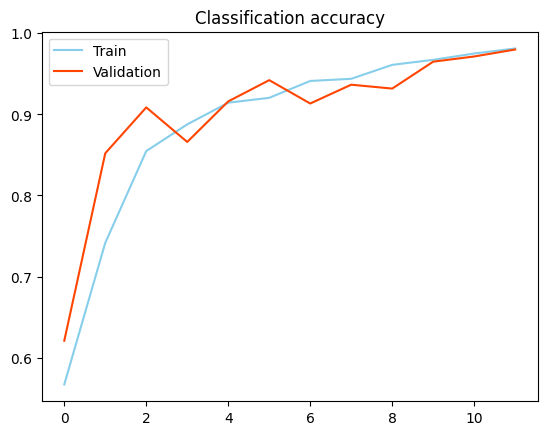

In [13]:
# Plot training & validation loss values
plt.title('Cross Entropy Loss')
plt.plot(history_drop.history['loss'], color='skyblue', label='train')
plt.plot(history_drop.history['val_loss'], color='orangered', label='test')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# Plot training & validation accuracy values
plt.title('Classification accuracy')
plt.plot(history_drop.history['accuracy'], color= 'skyblue', label = 'train' )
plt.plot(history_drop.history['val_accuracy'], color = 'orangered', label = 'test')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### **Confusion Matrix**

157/157 [==============================] - 4s 23ms/step


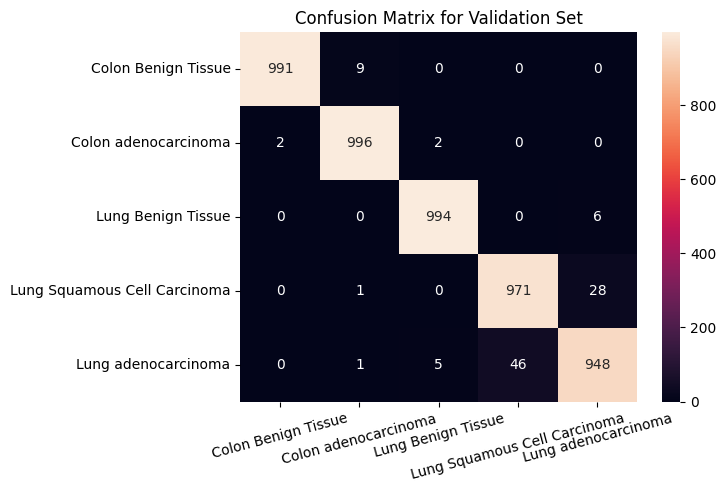

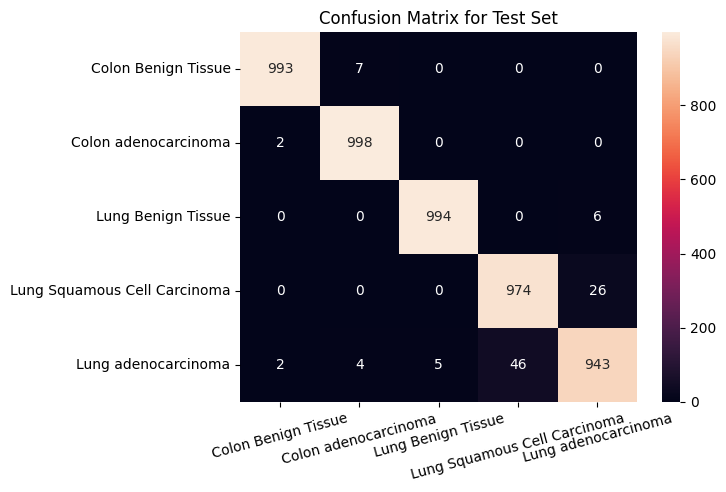

In [14]:
#Get predictions for both sets
y_val_pred_drop = model_drop.predict(X_val)
y_test_pred_drop = model_drop.predict(X_test)

# Convert predictions to class labels
y_val_pred_labels_drop = np.argmax(y_val_pred_drop, axis=1)
y_test_pred_labels_drop = np.argmax(y_test_pred_drop, axis=1)

# Convert observations to class labels
y_val_true = np.argmax(y_val, axis=1)
y_test_true = np.argmax(y_test, axis=1)

# Confusion matrix for the validation set
cm_val = confusion_matrix(y_val_true, y_val_pred_labels_drop)
sns.heatmap(cm_val, annot=True, fmt="d", xticklabels= u_labels, yticklabels=u_labels)
plt.title('Confusion Matrix for Validation Set')
plt.xticks(rotation=15)
plt.show()

# Confusion matrix for the test set
cm_test = confusion_matrix(y_test_true, y_test_pred_labels_drop)
sns.heatmap(cm_test, annot=True, fmt="d", xticklabels=u_labels, yticklabels=u_labels)
plt.title('Confusion Matrix for Test Set')
plt.xticks(rotation=15)
plt.show()

### **ROC Curve**

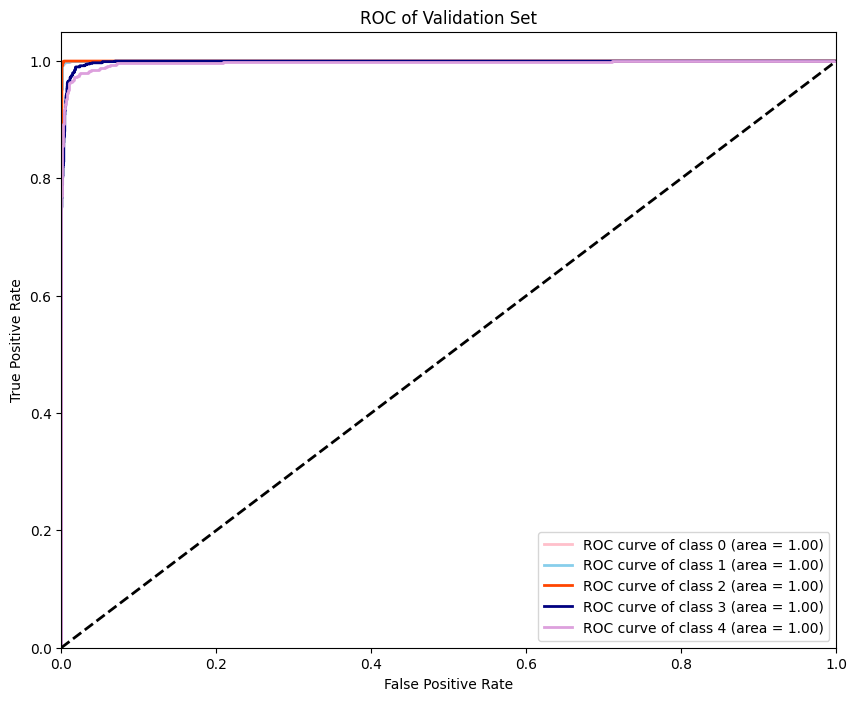

In [26]:
'''Validation Set'''
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_val_pred_drop[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

colors = ['pink', 'skyblue', 'orangered', 'navy', 'plum']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Validation Set')
plt.legend(loc="lower right")
plt.show()

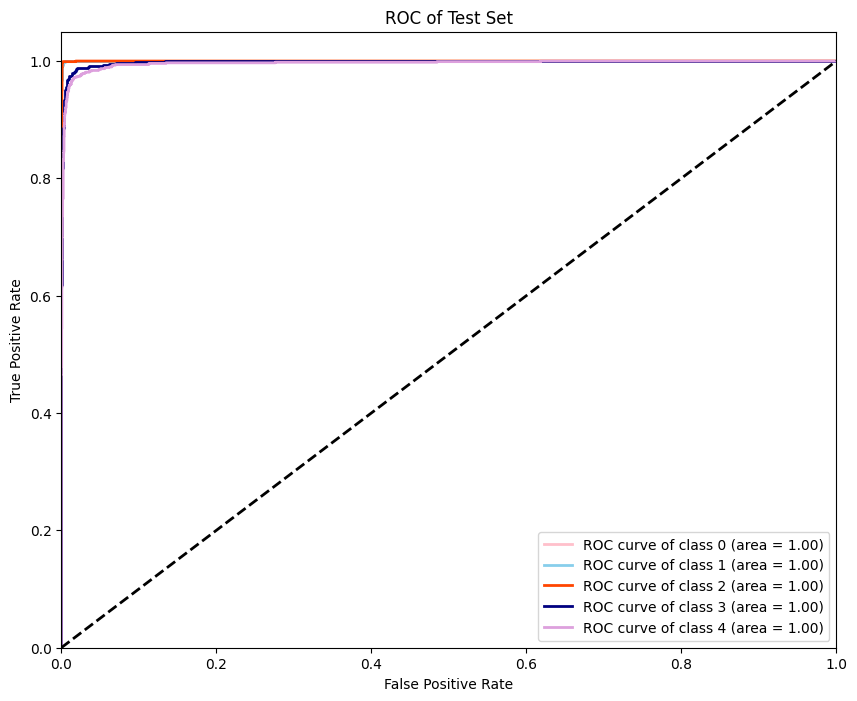

In [27]:
'''Test Set'''
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_test_pred_drop[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

colors = ['pink', 'skyblue', 'orangered', 'navy', 'plum']
for i, color in zip(range(5), colors[:5]):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Test Set')
plt.legend(loc="lower right")
plt.show()

### **Performance Metrics**

In [16]:
# Classification Report for Validation Set
report_val_drop = classification_report(y_val_true, y_val_pred_labels_drop, target_names=u_labels)
print('')
print(f'Evaluation Metrics of the Enhanced model - Validation set:\n{report_val_drop}')

# Classification Report for Test Set
report_test_drop = classification_report(y_test_true, y_test_pred_labels_drop, target_names=u_labels)
print(f'Evaluation Metrics of the Enhanced model - Test set:\n{report_test_drop}')


Evaluation Metrics of the Enhanced model - Validation set:
                              precision    recall  f1-score   support

         Colon Benign Tissue       1.00      0.99      0.99      1000
        Colon adenocarcinoma       0.99      1.00      0.99      1000
          Lung Benign Tissue       0.99      0.99      0.99      1000
Lung Squamous Cell Carcinoma       0.95      0.97      0.96      1000
         Lung adenocarcinoma       0.97      0.95      0.96      1000

                    accuracy                           0.98      5000
                   macro avg       0.98      0.98      0.98      5000
                weighted avg       0.98      0.98      0.98      5000

Evaluation Metrics of the Enhanced model - Test set:
                              precision    recall  f1-score   support

         Colon Benign Tissue       1.00      0.99      0.99      1000
        Colon adenocarcinoma       0.99      1.00      0.99      1000
          Lung Benign Tissue       0.99    

# **Transfer Learning Model - ResNet-50**

In [ ]:
# Load the ResNet50 model
model_transfer = ResNet50(include_top=False, input_tensor=Input(shape=X_train.shape[1:]))
# Freeze all the layers in the base model
for layer in model_transfer.layers:
    layer.trainable = False
# Add custom layers on top of the base model
flat1 = Flatten()(model_transfer.output)
class1 = Dense(256, activation='relu')(flat1)
class2 = Dense(64, activation='relu')(class1)
output = Dense(5, activation='softmax')(class2)
# Compile the model
model_tran = Model(inputs=model_transfer.input, outputs=output)
model_tran.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_transfer = model_tran.fit(X_train, y_train, epochs=12, batch_size=32, validation_data=(X_val, y_val))
test_loss_transfer, test_acc_transfer = model_tran.evaluate(X_test, y_test)

94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/14
469/469 [==============================] - 40s 73ms/step - loss: 0.2217 - accuracy: 0.9471 - val_loss: 0.0734 - val_accuracy: 0.9748
Epoch 2/14
469/469 [==============================] - 22s 48ms/step - loss: 0.0435 - accuracy: 0.9848 - val_loss: 0.0467 - val_accuracy: 0.9820
Epoch 3/14
469/469 [==============================] - 22s 46ms/step - loss: 0.0251 - accuracy: 0.9909 - val_loss: 0.0522 - val_accuracy: 0.9834
Epoch 4/14
469/469 [==============================] - 27s 58ms/step - loss: 0.0153 - accuracy: 0.9948 - val_loss: 0.0556 - val_accuracy: 0.9826
Epoch 5/14
469/469 [==============================] - 22s 46ms/step - loss: 0.0063 - accuracy: 0.9983 - val_loss: 0.0399 - val_accuracy: 0.9886
Epoch 6/14
469/469 [==============================] - 23s 48ms/step - loss: 0.0080 - accuracy: 0.9977 - val_loss: 0.0722 - val_accuracy: 0.9776
Epoch 7/14
469/469 [==============================] - 27s 58ms/step - l

### **ResNet-50 Model Summary**

In [ ]:
model_transfer.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 126, 126, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 60, 60, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 60, 60, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

## **Evaluation Metrics of ResNet-50**

### **Loss and Accuracy of ResNet-50**

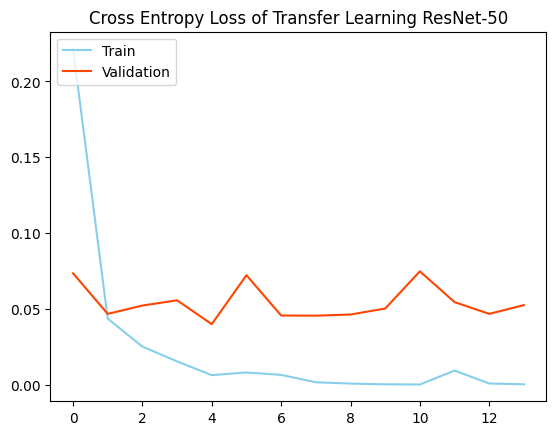

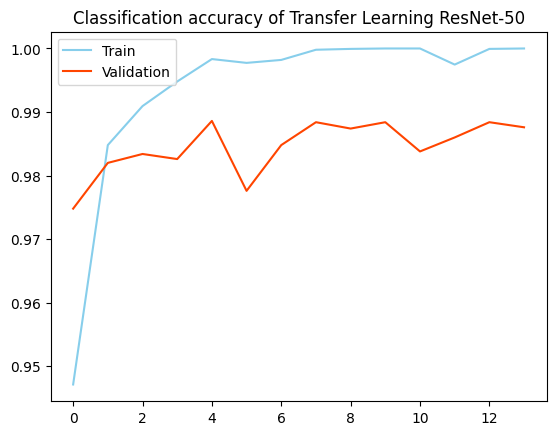

In [ ]:
# Training & validation loss values
plt.title('Cross Entropy Loss of Transfer Learning ResNet-50')
plt.plot(history_transfer.history['loss'], color='skyblue', label='train')
plt.plot(history_transfer.history['val_loss'], color='orangered', label='test')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Training & validation accuracy values
plt.title('Classification accuracy of Transfer Learning ResNet-50')
plt.plot(history_transfer.history['accuracy'], color= 'skyblue', label = 'train' )
plt.plot(history_transfer.history['val_accuracy'], color = 'orangered', label = 'test')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### **Confusion Matrix**

157/157 [==============================] - 5s 32ms/step


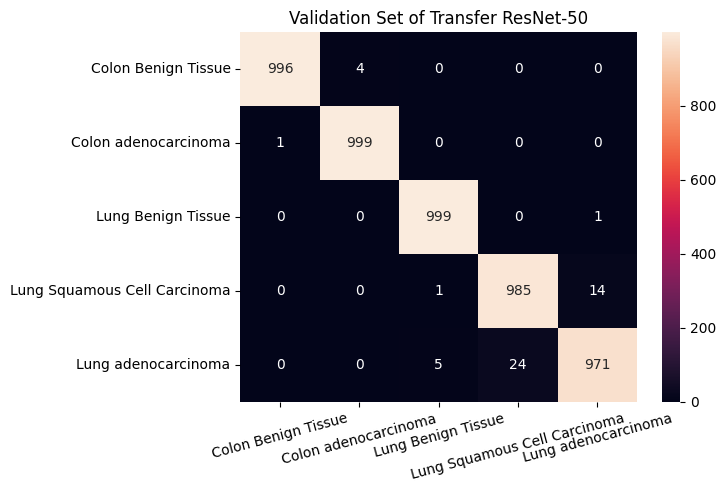

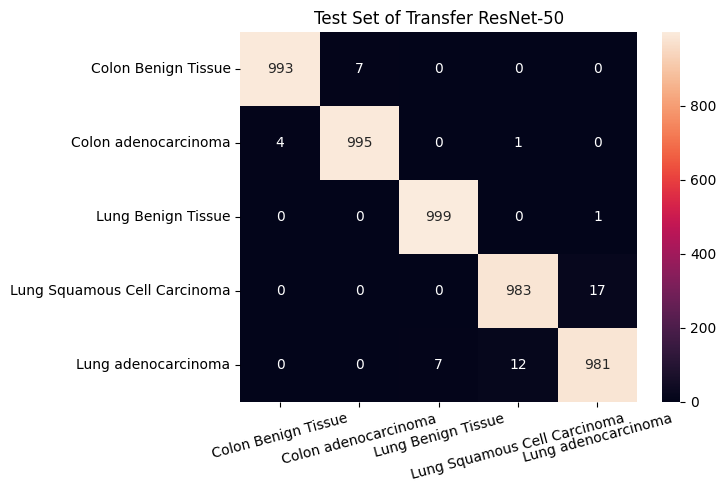

In [ ]:
y_val_pred_tran = model_tran.predict(X_val)
y_test_pred_tran = model_tran.predict(X_test)

# Convert predictions from probabilities to class labels
y_val_label_tran = np.argmax(y_val_pred_tran, axis=1)
y_test_label_tran = np.argmax(y_test_pred_tran, axis=1)

# Convert observed scores to class labels
y_val_true_tran = np.argmax(y_val, axis=1)
y_test_true_tran = np.argmax(y_test, axis=1)

# Confusion matrix for the validation set
cm_val = confusion_matrix(y_val_true_tran, y_val_label_tran)
sns.heatmap(cm_val, annot=True, fmt="d", xticklabels= u_labels, yticklabels=u_labels)
plt.title('Validation Set of Transfer ResNet-50')
plt.xticks(rotation=15)
plt.show()

# Confusion matrix for the test set
cm_test = confusion_matrix(y_test_true_tran, y_test_label_tran)
sns.heatmap(cm_test, annot=True, fmt="d", xticklabels=u_labels, yticklabels=u_labels)
plt.title('Test Set of Transfer ResNet-50')
plt.xticks(rotation=15)
plt.show()

### **ROC Curve**

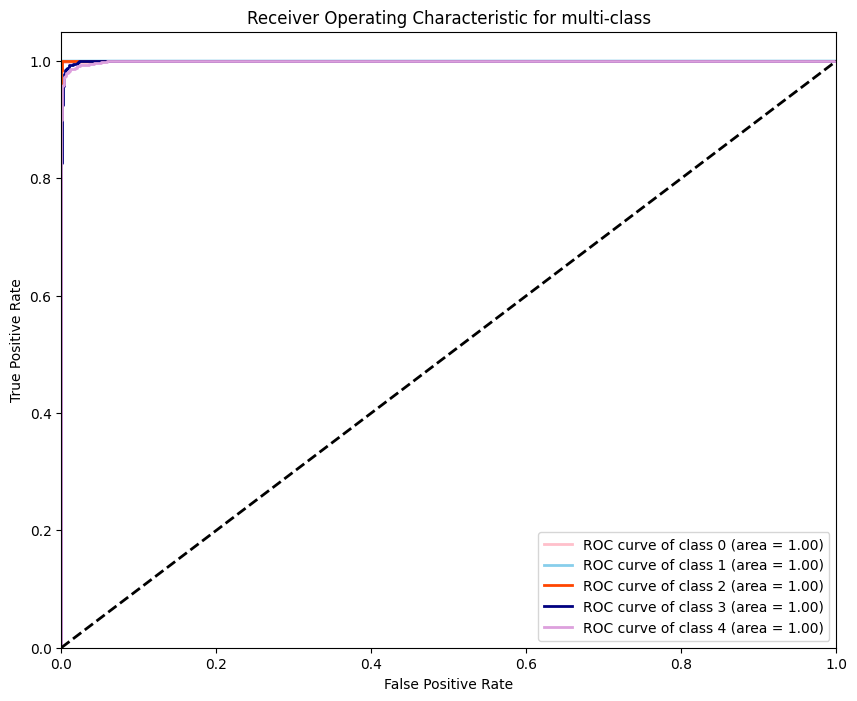

In [ ]:
'''Validation Set'''
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_val_pred_tran[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

colors = ['pink', 'skyblue', 'orangered', 'navy', 'plum']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class')
plt.legend(loc="lower right")
plt.show()

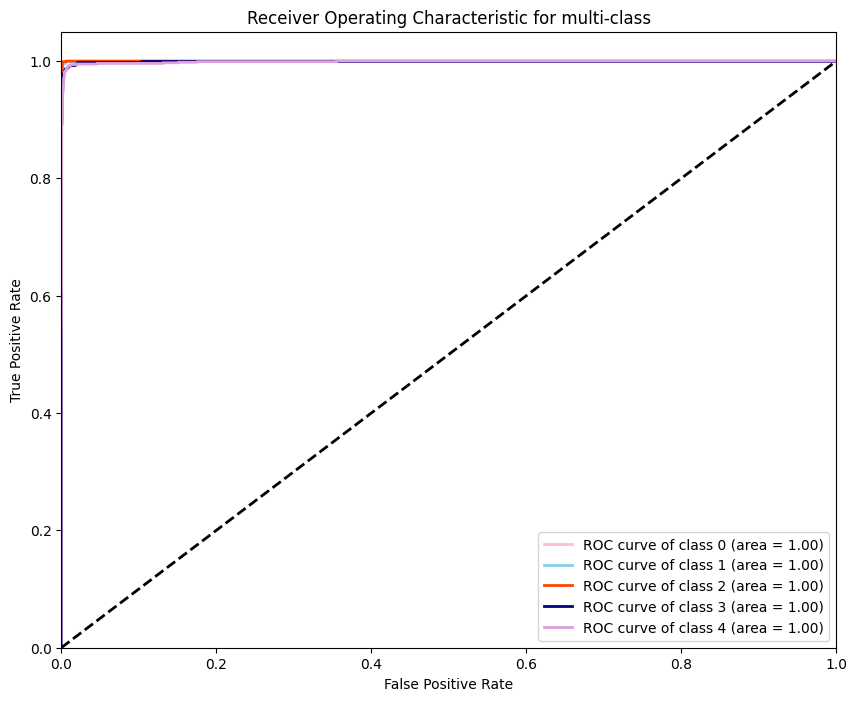

In [ ]:
'''Test Set'''
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_test_pred_tran[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

colors = ['pink', 'skyblue', 'orangered', 'navy', 'plum']
for i, color in zip(range(5), colors[:5]):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class')
plt.legend(loc="lower right")
plt.show()

### **Performance Metrics**

In [ ]:
# Classification Report for Validation Set
report_val_base = classification_report(y_val_true, y_val_label_tran, target_names=u_labels)
print('')
print(f'Evaluation Metrics of the Transfer model - Validation set:\n{report_val_base}')

# Classification Report for Test Set
report_test_base = classification_report(y_test_true, y_test_label_tran, target_names=u_labels)
print(f'Evaluation Metrics of the Transfer model - Test set:\n{report_test_base}')

157/157 [==============================] - 5s 33ms/step

Evaluation Metrics of the Transfer model - Validation set:
                              precision    recall  f1-score   support

         Colon Benign Tissue       1.00      1.00      1.00      1000
        Colon adenocarcinoma       0.99      0.99      0.99      1000
          Lung Benign Tissue       1.00      1.00      1.00      1000
Lung Squamous Cell Carcinoma       0.97      0.98      0.98      1000
         Lung adenocarcinoma       0.98      0.97      0.97      1000

                    accuracy                           0.99      5000
                   macro avg       0.99      0.99      0.99      5000
                weighted avg       0.99      0.99      0.99      5000

Evaluation Metrics of the Transfer model - Test set:
                              precision    recall  f1-score   support

         Colon Benign Tissue       1.00      1.00      1.00      1000
        Colon adenocarcinoma       0.99      1.00      1.